# PetFinder.my Pawpularity Score / Submit

## Imports

In [1]:
# Imports
import os
import numpy as np
from IPython.display import display

# Import utility libs
import petfinder_pawpularity_config as config
import petfinder_pawpularity_lib as mllib
tf_strategy = mllib.tf_strategy()

'TensorFlow Version: 2.8.0'

'TensorFlow Strategy: _DefaultDistributionStrategy'

'Built With GPU Support: True'

'Built With CUDA: True'

'Device: /device:GPU:0'

In [2]:
# Enable retina display
%config InlineBackend.figure_format = "retina"

# Load Tensorboard
%load_ext tensorboard

## Settings

In [3]:
# Settings
settings, debug = config.get_settings(
    process="submit",
    fallback_mode="full"
)
mllib.show_dict(settings)

'Settings: local-submit-full'

,Key,Value
0,debug,True
1,model_load_dir,models
2,model_save_dir,models
3,dataset_dir_src,../input/petfinder-pawpularity-score
4,dataset_dir_cut,../input/petfinder-pawpularity-score
5,dataset_dir_copy,dataset-copy
6,dataset_batch_size,64
7,dataset_image_size,"(150, 150)"
8,dataset_cut_ratio,1.0
9,dataset_shrink_ratio,1.0


## Prepare data

'../input/petfinder-pawpularity-score'

'Load test data from ../input/petfinder-pawpularity-score/test.csv'

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur
0,4128bae22183829d2b5fea10effdb0c3,1,0,1,0,0,1,1,0,0,1,0,1
1,43a2262d7738e3d420d453815151079e,0,1,0,0,0,0,1,1,0,0,0,0
2,4e429cead1848a298432a0acad014c9d,0,0,0,1,0,1,1,1,0,1,1,1
3,80bc3ccafcc51b66303c2c263aa38486,1,0,1,0,0,0,0,0,0,0,1,0
4,8f49844c382931444e68dffbe20228f4,1,1,1,0,1,1,0,1,0,1,1,0
5,b03f7041962238a7c9d6537e22f9b017,0,0,1,1,1,1,1,1,1,0,1,0
6,c978013571258ed6d4637f6e8cc9d6a3,1,0,0,0,1,1,0,1,0,1,1,1
7,e0de453c1bffc20c22b072b34b54e50f,1,0,1,0,0,0,0,0,1,0,0,1


Submission dataset items: 64

Submission dataset:
Cause: could not parse the source code of <function <lambda> at 0x7fd1dc058700>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7fd1dc058700>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


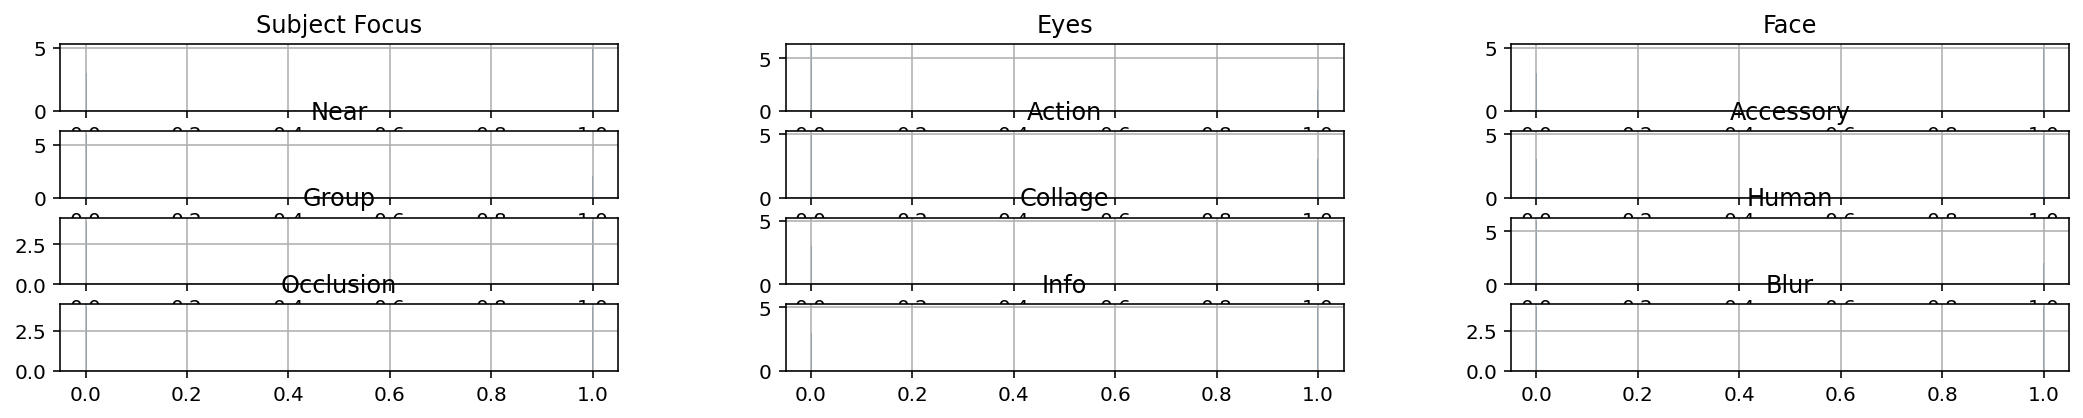

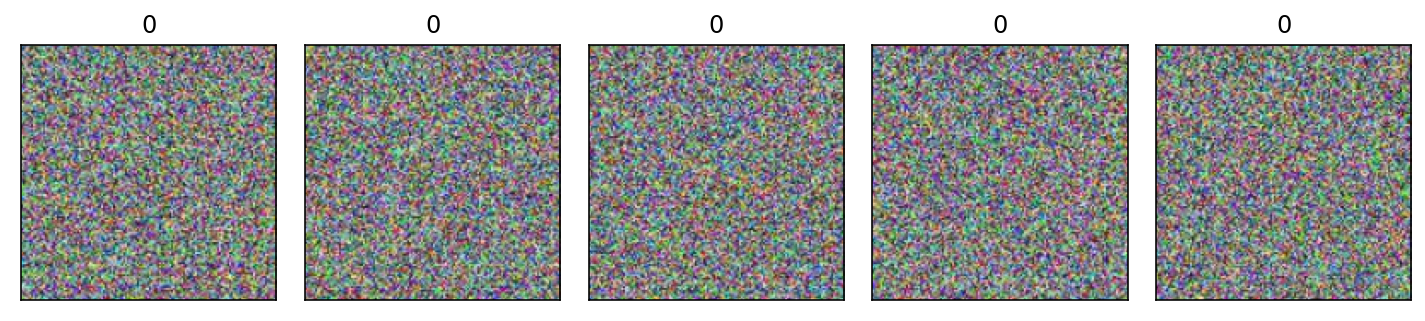

CPU times: user 8.26 s, sys: 509 ms, total: 8.77 s
Wall time: 8.37 s


In [4]:
%%time
# Cut training data
dataset_dir = mllib.cut_training_data(
    cut_ratio=settings["dataset_cut_ratio"], 
    dataset_dir_src=settings["dataset_dir_src"], 
    dataset_dir_cut=settings["dataset_dir_cut"]
)
display(dataset_dir)

# Submission data
submission_data = mllib.load_test_data(dataset_dir)
if debug: 
    display(submission_data)
    submission_data.hist(bins=500, figsize=(18,3))

# Make submission data
map_image_score_fn = lambda image, features, score, file_id: (image, score)  
submission_dataset = mllib.make_submission_data(
    dataset=mllib.load_test_dataset(
        dataset_dir=dataset_dir,
        mapping_data=submission_data,
        batch_size=settings["dataset_batch_size"],
        shuffle=settings["dataset_shuffle"],
        seed=settings["dataset_shuffle_seed"],
        image_size=settings["dataset_image_size"],
    ), 
    shrink_ratio=settings["dataset_shrink_ratio"],
    prefetch=settings["dataset_prefetch"],
)

# Submission data infos
print("Submission dataset items: %s" % (settings["dataset_batch_size"] * submission_dataset().cardinality().numpy()))
if debug:
    print("")
    print("Submission dataset:")
    mllib.plot_images_scores_from_dataset(submission_dataset().take(1).map(map_image_score_fn), with_stats=False)

## Submission

In [5]:
# Prepare model parameters
def get_model_parameters(settings):
    dataset_image_size = settings["dataset_image_size"]
    model_parameters = {
        "model_id": "model_1",
        "model_prefix": mllib.cut_suffix(settings["dataset_cut_ratio"]),
        "model_base": "xception",
        "input_shape": [dataset_image_size[0], dataset_image_size[1], 3],
        "input_shape_features": len(mllib.feature_fields),
        "output_size": 1,
        "dropout_rate": 0.3,
        "learning_rate": 5e-4,
        "dense_layers": "100",
        "dense_layers_activation": "elu",
        "preload_weights": None,
    }
    model_name = mllib.get_model_name(model_parameters)
    model_parameters["model_name"] = model_name
    return model_parameters
    
model_parameters = get_model_parameters(settings)
mllib.show_dict(model_parameters)

,Key,Value
0,model_id,model_1
1,model_prefix,
2,model_base,xception
3,input_shape,"[150, 150, 3]"
4,input_shape_features,12
5,output_size,1
6,dropout_rate,0.3
7,learning_rate,0.0005
8,dense_layers,100
9,dense_layers_activation,elu


In [6]:
%%time
# Load model
with tf_strategy.scope():
    model = mllib.setup_model(model_parameters)
    model_file = mllib.load_model(model, settings["model_load_dir"])
    print("Loaded Weights: %s" % model_file)

Model: "model_1-xception-input-150x150x3-dense-100-elu-dropout-0.300"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 150, 150, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 150, 150, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 150, 150, 3)      0         
 a)                                                              
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
      

In [7]:
%%time
# Submit not sample
with tf_strategy.scope():
    if not settings["submit_data_sample_flag"]:
        submission_data = mllib.make_submission_file(
            dataset=submission_dataset, 
            model=model, 
            submission_dir=settings["submission_dir"],
        )
        display(submission_data)

,Id,Pawpularity
0,4128bae22183829d2b5fea10effdb0c3,-0.00
1,43a2262d7738e3d420d453815151079e,-0.00
2,4e429cead1848a298432a0acad014c9d,-0.00
3,80bc3ccafcc51b66303c2c263aa38486,-0.00
4,8f49844c382931444e68dffbe20228f4,-0.00
5,b03f7041962238a7c9d6537e22f9b017,-0.00
6,c978013571258ed6d4637f6e8cc9d6a3,-0.00
7,e0de453c1bffc20c22b072b34b54e50f,-0.00


CPU times: user 3.16 s, sys: 645 ms, total: 3.8 s
Wall time: 3.77 s


In [8]:
%%time
# Submit sample
if settings["submit_data_sample_flag"]:
    submission_data = mllib.make_submission_sample_file(
        sample_dir=settings["dataset_dir_src"], 
        submission_dir=settings["submission_dir"]
    )
    display(submission_data)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 8.11 µs


## Cleanup

In [9]:
%%time
if settings["cleanup_data_flag"]: 
    mllib.delete_training_data(cut_ratio=settings["dataset_cut_ratio"], dataset_dir_cut=settings["dataset_dir_cut"])

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 8.11 µs
